<a href="https://colab.research.google.com/github/Bing-Chilling-07/BCS_Assignments/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LUNAR LANDER:**

## **installing all the required packages:**

In [1]:
pip install gymnasium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 17.6 MB/s eta 0:00:00


In [2]:
pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.6 MB/s eta 0:00:00


In [3]:
pip install gym[box2D]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 32.3 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376475 sha256=9d574fb4a4667df34d69f8877e7ee3dc6c8308290c2aaad8a7db92e38cc2ee4b
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.1
    Uninstalling pygame-2.6.1:
      Successfully uninstalled pygame-2.6.1


In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from IPython import get_ipython
from IPython.display import display, clear_output
from collections import namedtuple, deque
from itertools import count


## **Creating an environment:**

In [5]:
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)

## **creating a replay memory class for storing all the episodes and its output:**

In [6]:
transition = namedtuple('transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

  def __init__(self, capacity):
    self.memory = deque([], maxlen=capacity)

  def push(self, *arguements):
    self.memory.append(transition(*arguements))

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def length(self):
    return len(self.memory)


## **Neural Network class:**

In [7]:
class DQN(nn.Module):
  def __init__(self, n_obv,n_hidden, n_act):
    super(DQN, self).__init__()
    self.input = nn.Linear(n_obv, n_hidden)
    self.hidden = nn.Linear(n_hidden, n_hidden)
    self.output = nn.Linear(n_hidden, n_act)


  def forward(self, x):
    x = F.relu(self.input(x))
    x = F.relu(self.hidden(x))
    return self.output(x)

## **Initializing all the hyper-parameters:**

In [8]:
BATCH_SIZE = 128
GAMMA = 0.995
EPS_START = 0.99
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LEARN_RATE = 1e-2

In [9]:
n_act = env.action_space.n                #number of actions in the action space of the environment(4)
state, info = env.reset()                 #reset the state and info from the environment
n_obv = len(state)                        #number of observations in the state(8)

In [10]:
online_net = DQN(n_obv, 128, n_act)       #creating an constantly updating onine_network
target_net = DQN(n_obv, 128, n_act)       #creating a target_network which is soft updated with values from the online_network
target_net.load_state_dict(online_net.state_dict())       #initially copying all the weights of the online_network to the target_network

optimizer = optim.AdamW(online_net.parameters(), lr = LEARN_RATE, amsgrad = True)         #optimizing the online_network to minimize the loss function

## **create the action selection function using the epsilon-greedy method:**

In [11]:
replay_memory = ReplayMemory(101010)      #create a replay_memory from the replay memory class with length of 101010
import math


steps_done = 0
def action_selection(state):

  global steps_done

  sample = random.random()               #generating a random number for sample
  eps_treshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)            #changing the epsilon value with every step, initially the eps value is equal to eps start, but slowly it will migrate to the eps_end value

  steps_done += 1
  if sample > eps_treshold:
    with torch.no_grad():
      return online_net(state).max(1).indices.view(1,1)          #generating the max value action if the sample is greater than the threshold (exploitation)

  else:
    return torch.tensor([[env.action_space.sample()]], dtype = torch.long)         #generating a random action if the sample is less than the threshold (exploration)


## **Creating the plot function:**

In [20]:
episode_rewards = []   #store the rewards for each episode to plot

def plot_rewards(show_result=False):
  plt.figure(1)
  rewards_t = torch.tensor(episode_rewards, dtype=torch.float)

  plt.figure(figsize=(14, 10))
  if show_result:
    plt.title('Result')

  else:
    plt.clf()
    plt.title("training . . .")
  plt.xlabel("Episode")
  plt.ylabel("Reward")
  plt.plot(rewards_t.numpy())

  if len(rewards_t) >=100:                                #plot a second mean function
    means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99), means))

    plt.plot(means.numpy())


  plt.pause(0.01)

  if get_ipython() is not None:
    if not show_result:
      print("Training . . .")
      clear_output(wait=True)
    else:
      display(plt.gcf())



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Creating the Optimizing function:**

In [21]:
def optimize_model():
  if replay_memory.length() < BATCH_SIZE:            #maintaining a minimum batch size to be used for optimizing function
    return
  transitions = replay_memory.sample(BATCH_SIZE)     #sampling random episodes to train from the replay_memory
  batch = transition(*zip(*transitions))             #maintaining a batch of all the required info to access directly from the initial namedtuple
  mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)        #a mask of type torch-tensor-boolean which tells if the state has a next_state or not

  next_states = torch.cat([s for s in batch.next_state if s is not None])
  state_batch = torch.cat(batch.state)
  action_batch = torch.cat(batch.action)
  reward_batch = torch.cat(batch.reward)

  state_action_values = online_net(state_batch).gather(1, action_batch)         #gather all the action values produced by the DQN, when given the state_batch

  next_state_values = torch.zeros(BATCH_SIZE)

  with torch.no_grad():
    next_state_values[mask] = target_net(next_states).max(1).values

  expected_state_action_values = (next_state_values * GAMMA) + reward_batch
  criterion = nn.SmoothL1Loss()                                                                 #calculating the huber_loss
  loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

  optimizer.zero_grad()
  loss.backward()                                                                       #calculating the loss and optimizing the network to minimize the loss
  torch.nn.utils.clip_grad_value_(online_net.parameters(), 100)
  optimizer.step()



## **training the Online_Network:**

Done


<Figure size 640x480 with 0 Axes>

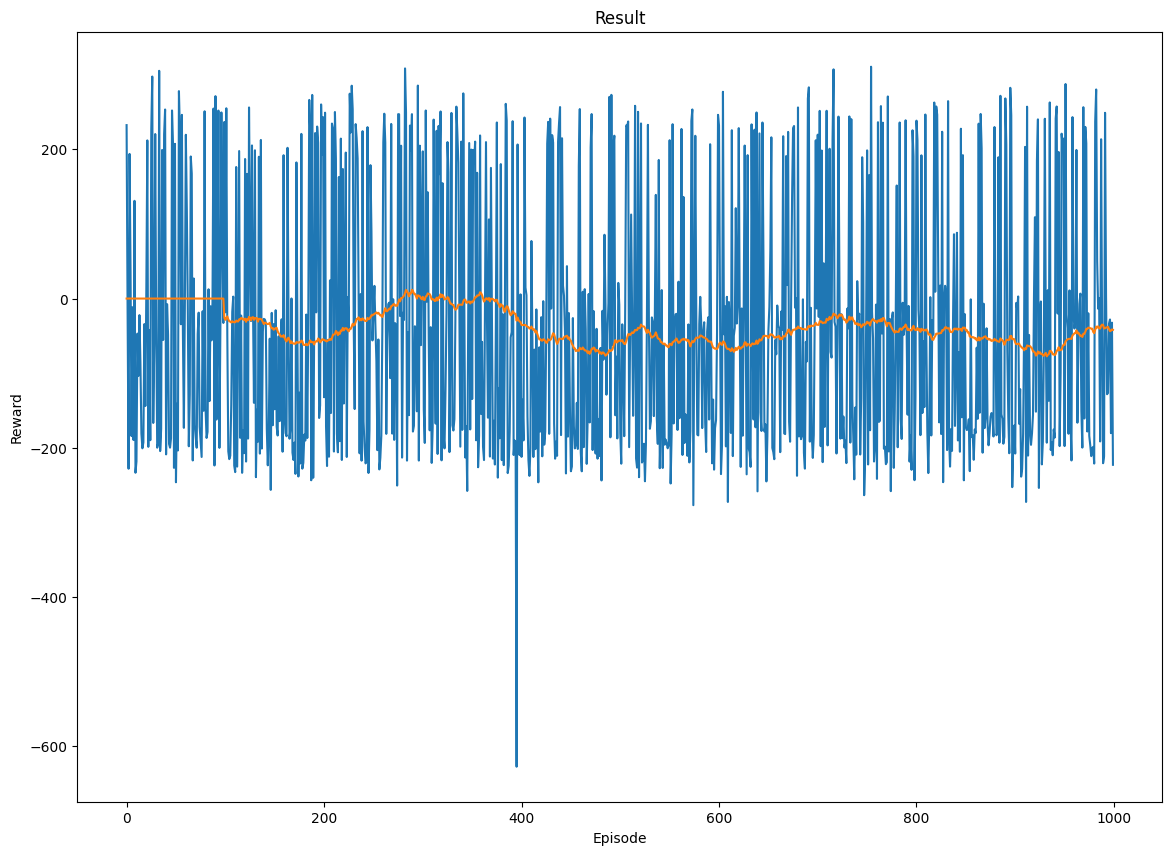

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [22]:
from types import new_class
iterations_epi = 1000

for i in range(iterations_epi):
  state, info = env.reset()
  state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)              #convert the state into a state tensor

  total_reward = 0

  for t in count():
    action = action_selection(state)                                             # select an action based on the state
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward])

    total_reward += reward.item()

    if terminated:
      next_state = None

    else:
      next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)            #the next_state is the observation after the action is completed


    replay_memory.push(state, action, next_state, reward)

    state = next_state

    optimize_model()

    #soft updating the weights in target net using the weights from the online_net
    target_net_state_dict = target_net.state_dict()
    online_net_state_dict = online_net.state_dict()
    for key in online_net_state_dict:
      target_net_state_dict[key] = online_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)

    if (terminated or truncated):
      episode_rewards.append(total_reward)
      break
print('Done')
plot_rewards(show_result=True)
plt.ioff()
plt.show()


In [23]:
largest = max(episode_rewards)
print(largest)

310.66306080473913


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def show_video_of_model(env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)

        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = action_selection(state_tensor)
        state, reward, done, _, _ = env.step(action.item())
    env.close()
    imageio.mimsave('video.mp4', frames, fps=30)

show_video_of_model('LunarLander-v3')

def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()